<a href="https://colab.research.google.com/github/Untick/NetOptik/blob/main/Shironin%20Igor/%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B0_%D0%BA%D0%BE%D0%B4%D1%8B4_%22%22yolav8n_'_%D0%A4%D0%B8%D0%BD%D0%B0%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F_%D0%B2%D0%B5%D1%80%D1%81%D0%B8%D1%8F%22%22%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ** Модель нейросети по распознаванию атрибутов очков с дужки:**

*Задача стажера: создание модели, которая будет распознавать символы кода с дужки очков и сопоставлять эти коды с записями в таблице атрибутов для определения параметров и модели очков. В качестве данных используются предоставленные Заказчиком фотографии символьного кода на дужках и таблица атрибутов к ним.

    
    

Для решения задачи была использована библиотека ultralytics и модель yolov8n.

Для подачи данных в модель для обучения фотографии символьного кода , предоставленные заказчиком, были предварительно преведены к общей размерности  640x640.

Так как заказчиком было представленно только 96 качественных фото, то была применена аугментация. Каждое изображение было аугментированно 5 раз. Применялось отражение, поворрот на небольшой угол( не более 10%), изменение яркости и контрастности. В результате было получено 480 изображений, 45 было использованно в валидационной выборке и 45 было оставленно на тестовую.

Потом эти фото были размечены с помощью прграммы CVAT.

Полученные размеченные изображения были разнесены по папкам и  упакованны в ахив 'glasses_data.zip', сохраненный на гугл диск.







В этом блокноте :

 устанавливаем зависимости ultralytics,

 загружаем подготовленные изображения,

  создаем файл data.yaml, хранящий информацию о выборках и метках.
  
   Загружаем и обучаем модель yolov8n.

   Сохраняем все данные по обучению на гугл диск.
   
   Загружаем лучшшую модель и уже с ней работаем.

   



Для прочтения кода с дужки очков берем предсказания модели для конкретного изображения , обрезаем его по предсказанным меткам и с помощью метода pytesseract читаем код.

Загружаем таблицу атрибутов предоставленную заказчиком. Чистим от ненужных данных и пустых строк.

Сравниваем полученную при предсказании надпись с кодами из таблицы. Для этого считаем кол-во совпадающих элементов и выводим надпись с максимумом совпадающих символов.

# Установка зависимостей ultralytics

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/107.7 GB disk)


# Загрузка датасета

In [ ]:
import os

# Загрузка датасета https://drive.google.com/file/d/1VjH0WxIG6JMwsLlPWPUxCPUPPCpxPv0o/view?usp=sharing

PATH_DATA = '/content/glasses_arm_tag/'
PATH_DATA_YAML = PATH_DATA +'data.yaml'

%mkdir -p $PATH_DATA
%cd $PATH_DATA

FILE_ID = '1VjH0WxIG6JMwsLlPWPUxCPUPPCpxPv0o'
FILE_NAME = 'glasses_data.zip'

!gdown 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O {FILE_NAME}

!unzip -q -o $FILE_NAME

os.remove(os.path.join(PATH_DATA, FILE_NAME))

/content/glasses_arm_tag
Downloading...
From: https://docs.google.com/uc?export=download&id=1VjH0WxIG6JMwsLlPWPUxCPUPPCpxPv0o
To: /content/glasses_arm_tag/glasses_data.zip
100% 5.88M/5.88M [00:00<00:00, 228MB/s]


# Создание  data.yaml

In [ ]:
IMAGE_PATH_train = '/content/glasses_arm_tag/train/images'#- изображения для тренировочной выборки
IMAGE_PATH_val = '/content/glasses_arm_tag/valid/images'#-изображения для валидационной выборке
IMAGE_PATH_test = '/content/glasses_arm_tag/test/images'#- изображения для тестовой выборки

In [ ]:
import os

image_files = os.listdir(IMAGE_PATH_train)
with open('train.txt', 'w') as f:
    for image in image_files:
        if image.endswith('.jpg'):
            f.write(os.path.join(IMAGE_PATH_train, image) + '\n')


# Создайте файл val.txt, в котором перечислите пути к валидационным изображениям:
import os

image_files = os.listdir(IMAGE_PATH_val)
with open('val.txt', 'w') as f:
    for image in image_files:
        if image.endswith('.jpg'):
            f.write(os.path.join(IMAGE_PATH_val, image) + '\n')

image_files = os.listdir(IMAGE_PATH_test)
with open('val.txt', 'w') as f:
    for image in image_files:
        if image.endswith('.jpg'):
            f.write(os.path.join(IMAGE_PATH_test, image) + '\n')

In [ ]:
import yaml

data = {
    'train': IMAGE_PATH_train,
    'val': IMAGE_PATH_val,
    'test': IMAGE_PATH_test,
    'nc': 1,
    'names': ['metka']
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f)

In [ ]:
!cat $PATH_DATA_YAML

names:
- metka
nc: 1
test: /content/glasses_arm_tag/test/images
train: /content/glasses_arm_tag/train/images
val: /content/glasses_arm_tag/valid/images


# Загрузка модели

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.yaml')  # build a new model from scratch
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

## Тренировка

In [ ]:
# Use the model
model.train(data="data.yaml", epochs=100,nms=True )
model.val()

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79c9e4438370>
fitness: 0.8224431070839179
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.80327])
names: {0: 'metka'}
plot: True
results_dict: {'metrics/precision(B)': 0.9982703426346732, 'metrics/recall(B)': 1.0, 'metrics/mAP50(B)': 0.995, 'metrics/mAP50-95(B)': 0.803270118982131, 'fitness': 0.8224431070839179}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 6.074168947007921, 'inference': 28.841691546969944, 'loss': 0.0013669331868489583, 'postprocess': 2.637783686319987}

In [ ]:


import shutil

shutil.make_archive("/content/drive/MyDrive/model/yolov8n", 'zip', "/content/glasses_arm_tag")

# # Вышеуказанный код создаст архив yolov8n.zip из директории `/content/glasses_arm_tag` и сохранит его
# на свой Google Drive в директории `/content/drive/My Drive/model`.

'/content/drive/MyDrive/model/yolov8n.zip'

У меня гугл диск был подключен с помощью панели управления. Можно использовать код приведенный ниже

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# /content/drive/MyDrive/model/glasses_arm_tag/runs/detect (1)/train/weights/best.pt

In [ ]:
MODEL_PATH = '/content/drive/MyDrive/model/glasses_arm_tag/runs/detect (1)/train/weights/best.pt'
model = YOLO(MODEL_PATH)  # Load the custom model

# Validate the model
metrics = model.val()
print('map50-95', metrics.box.map)
print('map50', metrics.box.map50)
print('map75', metrics.box.map75)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
100%|██████████| 755k/755k [00:00<00:00, 35.6MB/s]
val: Scanning /content/glasses_arm_tag/valid/labels... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<00:00, 1531.59it/s]
val: New cache created: /content/glasses_arm_tag/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:22<00:00,  7.58s/it]
                   all         45         45      0.998          1      0.995      0.803
Speed: 16.6ms preprocess, 460.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/val


map50-95 0.803270118982131
map50 0.995
map75 0.9438674658674661


In [ ]:
# Загрузка модуля pandas
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/model/glasses_arm_tag/runs/detect (1)/train/results.csv')
df

,epoch,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,0,2.00130,2.95210,1.89560,0.00333,1.00000,0.72100,0.32514,1.63250,3.65930,1.72460,0.000460,0.000460,0.000460
1,1,1.59950,2.10410,1.36760,0.42910,0.37778,0.34245,0.13943,1.96860,4.29120,1.76320,0.000931,0.000931,0.000931
2,2,1.59250,2.05580,1.35580,0.66613,0.77778,0.82729,0.40049,1.59560,2.48130,1.90180,0.001392,0.001392,0.001392
3,3,1.56000,1.80140,1.34470,0.82368,0.82222,0.89477,0.39317,1.52630,3.12280,1.60970,0.001844,0.001844,0.001844
4,4,1.49700,1.72840,1.32540,0.40858,0.51111,0.40094,0.07402,2.91860,3.19740,3.89570,0.001921,0.001921,0.001921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.74714,0.41819,0.94873,0.99759,1.00000,0.99500,0.78431,0.80289,0.40632,0.88459,0.000139,0.000139,0.000139
96,96,0.74813,0.41122,0.96666,0.99748,1.00000,0.99500,0.76818,0.83902,0.40838,0.89206,0.000119,0.000119,0.000119
97,97,0.73965,0.41315,0.96573,0.99667,1.00000,0.99500,0.78502,0.82202,0.39632,0.88944,0.000099,0.000099,0.000099
98,98,0.71826,0.40788,0.96667,0.99651,1.00000,0.99500,0.79178,0.79967,0.39078,0.88479,0.000079,0.000079,0.000079


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0                     epoch  100 non-null    int64  
 1            train/box_loss  100 non-null    float64
 2            train/cls_loss  100 non-null    float64
 3            train/dfl_loss  100 non-null    float64
 4      metrics/precision(B)  100 non-null    float64
 5         metrics/recall(B)  100 non-null    float64
 6          metrics/mAP50(B)  100 non-null    float64
 7       metrics/mAP50-95(B)  100 non-null    float64
 8              val/box_loss  100 non-null    float64
 9              val/cls_loss  100 non-null    float64
 10             val/dfl_loss  100 non-null    float64
 11                   lr/pg0  100 non-null    float64
 12                   lr/pg1  100 non-null    float64
 13                   lr/pg2  100 non-null    float64
dtypes: float64(13), int64(1)
me

In [ ]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
   

In [ ]:
metrics = model.val()
path = model.export(format="onnx")

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
val: Scanning /content/glasses_arm_tag/valid/labels.cache... 45 images, 0 backgrounds, 0 corrupt: 100%|██████████| 45/45 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:17<00:00,  5.93s/it]
                   all         45         45      0.998          1      0.995      0.803
Speed: 10.1ms preprocess, 369.3ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val2
Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from '/content/drive/MyDrive/model/glasses_arm_tag/runs/detect (1)/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (6.0 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 106.1 MB/

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



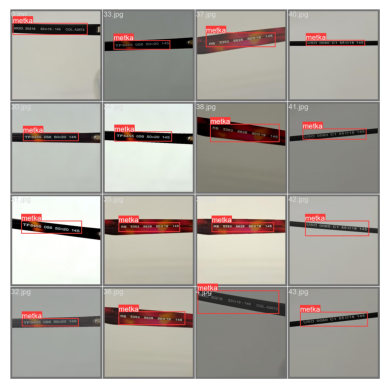

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Загрузка изображения

IGM_PATH = '/content/drive/MyDrive/model/glasses_arm_tag/runs/detect (1)/val/val_batch0_labels.jpg'

image = Image.open(IGM_PATH)

# Показ изображения
plt.imshow(image)
plt.axis('off')
plt.show()

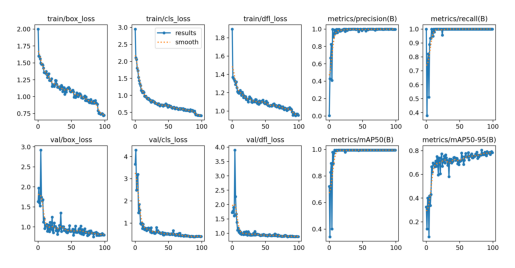

In [ ]:
IGM_PATH = '/content/drive/MyDrive/model/glasses_arm_tag/runs/detect (1)/train/results.png'

image = Image.open(IGM_PATH)

# Показ изображения
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
TEST_FILE = '/content/glasses_arm_tag/test/images/18.jpg'

In [ ]:
from ultralytics import YOLO
from PIL import Image
import cv2

model = YOLO(MODEL_PATH)
# accepts all formats - image/dir/Path/URL/video/PIL/ndarray. 0 for webcam
# results = model.predict(source="0")
# results = model.predict(source="folder", show=True) # Display preds. Accepts all YOLO predict arguments

# from PIL
im1 = Image.open(TEST_FILE )
results = model.predict(source=im1, save=True)  # save plotted images

# from ndarray
im2 = cv2.imread(TEST_FILE)
results = model.predict(source=im2, save=True, save_txt=True)  # save predictions as labels

# from list of PIL/ndarray
results = model.predict(source=[im1, im2])


0: 640x640 1 metka, 533.1ms
Speed: 3.5ms preprocess, 533.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

0: 640x640 1 metka, 564.9ms
Speed: 5.0ms preprocess, 564.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels

0: 640x640 1 metka, 1: 640x640 1 metka, 688.9ms
Speed: 3.8ms preprocess, 344.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
3 labels saved to runs/detect/predict/labels


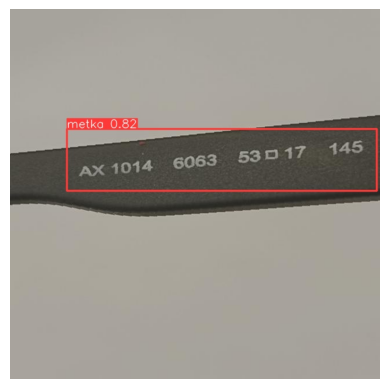

In [ ]:
im1_pred = Image.open('/content/glasses_arm_tag/runs/detect/predict/image0.jpg')
plt.imshow(im1_pred)

plt.axis('off')
plt.show()

# Обрезка

In [ ]:
def apply_bboxes_on_image(img, boxes):
  fig, ax = plt.subplots(1)
  ax.imshow(img)

  for box in boxes:
    x_min, y_min, x_max, y_max = box[:4]
    rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

  plt.axis('off')
  plt.show()

In [ ]:
def crop_image_using_bboxes(image, boxes):
    cropped_images = []

    for box in boxes:
        x_min, y_min, x_max, y_max = box[:4]
        cropped_image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
        cropped_images.append(cropped_image)

    return cropped_images

In [ ]:
def display_image(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [ ]:
# TEST_FILE = '/content/drive/MyDrive/AI/datasets/glasses_arm_tags/test/10.jpg'

# # Load model
# predict_model = YOLO(MODEL_PATH)

# # Load image
# resized_img = resize_image_for_predict(TEST_FILE)

# Predict
results = model.predict(im1, max_det=1)

# Write result
# apply_bboxes_on_image(im1, results[0].boxes.data)


0: 640x640 1 metka, 355.1ms
Speed: 3.0ms preprocess, 355.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
3 labels saved to runs/detect/predict/labels


In [ ]:
TEST_FILE = '/content/glasses_arm_tag/test/images/18.jpg'

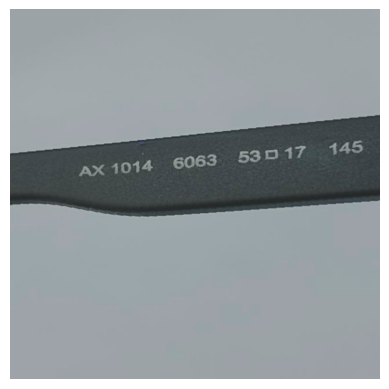

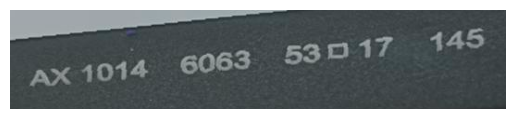

In [ ]:
im = cv2.imread(TEST_FILE)
display_image(im)

imgs = crop_image_using_bboxes(im, results[0].boxes.data)

for img in imgs:
  display_image(img)

In [ ]:
# Для установки и использования pytesseract в Google Colab, выполните следующие шаги:

# 1. Установите pytesseract и tesseract-ocr:
!pip install pytesseract
!apt-get install tesseract-ocr


# # 2. Далее, необходимо установить пакет, содержащий данные для распознавания на разных языках.
# # Например, для английского языка:
!apt-get install tesseract-ocr-eng


# 3. Импортируйте необходимые библиотеки в своем ноутбуке:
import pytesseract
from PIL import Image




Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 17 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (24.3 MB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 120901 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-e

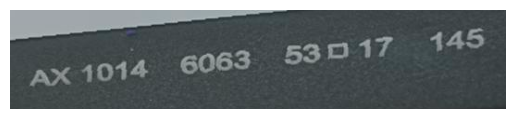

Ax 1014 6063 53017 145



In [ ]:
# Чтение текста pytesseract
extracted_text = pytesseract.image_to_string(imgs[0])

display_image(imgs[0])
print(extracted_text)

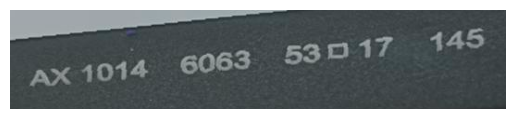

In [ ]:
# # 4. Загрузите изображение, на котором вы хотите распознать текст, например:
# img_path = data_files_atributs[1]
# image = Image.open(img_path)

display_image(img)
# 5. Вызовите функцию pytesseract.image_to_string(), передав в нее загруженное изображение:
text = pytesseract.image_to_string(img)

In [ ]:
print(text) # не все надписи распознаются

Ax 1014 6063 53017 145



# Загрузка таблицы атрибутов

In [ ]:
# Загрузка файла из гуглдиска в colab
import gdown
# https://drive.google.com/file/d/1NhdijuvNnIeSYFVGfrMUmhFaShPkWlQX/view?usp=sharing
f_1 = '1NhdijuvNnIeSYFVGfrMUmhFaShPkWlQX'# нужна только эта часть ссылки
gdown.download(f'https://drive.google.com/uc?id={f_1}', None, quiet=True)

'Атрибуты_3.xlsx - Лист1.csv'

In [ ]:
df = pd.read_csv('/content/glasses_arm_tag/Атрибуты_3.xlsx - Лист1.csv')
df

,п/н,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,1,NaN,RB 4246V 5240 47*19 140,RB 4246V 5240,47.0,19.0,140.0,113.0
1,2,NaN,RB 5353 5628 50*19 145,RB 5353 5628,50.0,19.0,145.0,119.0
2,3,NaN,RB 3747V 2500 47*21 140,RB 3747V 2500,47.0,21.0,140.0,115.0
3,4,NaN,RB 7084 5635 54*18 140,RB 7084 5635,54.0,18.0,140.0,126.0
4,5,NaN,RB 7086 2000 51*18 140,RB 7086 2000,51.0,18.0,140.0,120.0
...,...,...,...,...,...,...,...,...
1012,1013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013,1014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1014,1015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1015,1016,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Переименование столбцов и удаление пустых строчек

In [ ]:
df.rename(columns={'п/н': 'N'}, inplace=True)
df.rename(columns={'Unnamed: 1': 'Пустой'}, inplace=True)
df.rename(columns={'Unnamed: 2': 'Код'}, inplace=True)
df.rename(columns={'Unnamed: 3': 'Короткий код'}, inplace=True)
df.rename(columns={'Unnamed: 4': 'Атрибут1'}, inplace=True)
df.rename(columns={'Unnamed: 5': 'Атрибут2'}, inplace=True)
df.rename(columns={'Unnamed: 6': 'Атрибут3'}, inplace=True)
df.rename(columns={'Unnamed: 7': 'Атрибут4'}, inplace=True)
display(df)

,N,Пустой,Код,Короткий код,Атрибут1,Атрибут2,Атрибут3,Атрибут4
0,1,NaN,RB 4246V 5240 47*19 140,RB 4246V 5240,47.0,19.0,140.0,113.0
1,2,NaN,RB 5353 5628 50*19 145,RB 5353 5628,50.0,19.0,145.0,119.0
2,3,NaN,RB 3747V 2500 47*21 140,RB 3747V 2500,47.0,21.0,140.0,115.0
3,4,NaN,RB 7084 5635 54*18 140,RB 7084 5635,54.0,18.0,140.0,126.0
4,5,NaN,RB 7086 2000 51*18 140,RB 7086 2000,51.0,18.0,140.0,120.0
...,...,...,...,...,...,...,...,...
1012,1013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1013,1014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1014,1015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1015,1016,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['Пустой'] = 'Пустой' # Замена всех значений столбца Пустой на слово Пустой

In [ ]:
df = df.dropna(how='any') # Удаление всех строк, в которых есть хоть один пропуск
# 97 строка тоже удалилась
# Восстановление индексации
df = df.reset_index(drop=True)
# Восстановление нумерации
for i in range(len(df.Код)) :
  df.N[i] = i+1

<ipython-input-34-a130dff201c1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.N[i] = i+1


In [ ]:
df

,N,Пустой,Код,Короткий код,Атрибут1,Атрибут2,Атрибут3,Атрибут4
0,1,Пустой,RB 4246V 5240 47*19 140,RB 4246V 5240,47.0,19.0,140.0,113.0
1,2,Пустой,RB 5353 5628 50*19 145,RB 5353 5628,50.0,19.0,145.0,119.0
2,3,Пустой,RB 3747V 2500 47*21 140,RB 3747V 2500,47.0,21.0,140.0,115.0
3,4,Пустой,RB 7084 5635 54*18 140,RB 7084 5635,54.0,18.0,140.0,126.0
4,5,Пустой,RB 7086 2000 51*18 140,RB 7086 2000,51.0,18.0,140.0,120.0
...,...,...,...,...,...,...,...,...
213,214,Пустой,FPVN002 LIL 44*15 120,FPVN002 LIL,44.0,15.0,120.0,103.0
214,215,Пустой,FPVN002 VLT 44*15 120,FPVN002 VLT,44.0,15.0,120.0,103.0
215,216,Пустой,FPVN003 CHR 46*14 120,FPVN003 CHR,46.0,14.0,120.0,106.0
216,217,Пустой,FPVN003 BLUE 46*14 120,FPVN003 BLUE,46.0,14.0,120.0,106.0


# поиск прочитанной надписи в таблице

In [ ]:
def text_list (text):
  text = text.upper() # переводим в верхний регистр
  text = text.replace('*','0') # заменим * на 0
  text = list(text) # переводим в список
  return text

In [ ]:
# сравнение двух списков( находит к-во совпадающих элементов)
def comparison( list1, list2):
  common_elements = set(list1).intersection(list2)
  a = len(common_elements)
  return a

In [ ]:
# нахождение строчки в таблице
def tab_row(text, df):
  s_rows = df.shape[0]
  row = 0
  c = 0
  for i in range(s_rows):
    a = comparison(text_list(df['Код'][i]),text_list (text))
    if a > c:
      row = i
      c = a
  return row

In [ ]:
print(text) # найденный текст на дужке


Ax 1014 6063 53017 145



In [ ]:
df['Код'][tab_row(text, df)] # Код в таблице атрибутов

'AX 1014 6063 53*17 145'

In [ ]:
df[tab_row(text, df):tab_row(text, df)+1] # строка в таблице атрибутов

,N,Пустой,Код,Короткий код,Атрибут1,Атрибут2,Атрибут3,Атрибут4
21,22,Пустой,AX 1014 6063 53*17 145,AX 1014 6063,53.0,17.0,145.0,123.0


Вывод: При такой маленькой базе для обучения на удивление был получен достойный результат. Если загружать изображение жорошего качества и в таблице атрибутов будет код, находящийся на дужке то модель справиться